# Yelp Sentiment Analysis with doc2vec Document Vectors

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pathlib import Path
import logging
from random import shuffle

import numpy as np
import pandas as pd

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from nltk import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### Settings

In [4]:
sns.set_style('white')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Paths

In [5]:
data_path = Path('..', 'data', 'yelp')

In [6]:
results_path = Path('results', 'yelp')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Logging Config

In [7]:
logging.basicConfig(
        filename=results_path / 'doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

Refer to download information [here](../data/create_yelp_review_data.ipynb).

We'll create a smaller sample of 100,000 reviews per star rating.

In [8]:
df = pd.read_parquet(data_path / 'user_reviews.parquet').loc[:, ['stars', 'text']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8021122 entries, 0 to 8021121
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   stars   float64
 1   text    object 
dtypes: float64(1), object(1)
memory usage: 183.6+ MB


In [10]:
df.stars.value_counts()

5.0    3586460
4.0    1673404
1.0    1283897
3.0     842289
2.0     635072
Name: stars, dtype: int64

In [11]:
stars = range(1, 6)

In [12]:
sample = pd.concat([df[df.stars == s].sample(n=100000) for s in stars])

In [13]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 7812276 to 4618307
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   500000 non-null  float64
 1   text    500000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.4+ MB


In [14]:
sample.stars.value_counts()

3.0    100000
5.0    100000
4.0    100000
2.0    100000
1.0    100000
Name: stars, dtype: int64

In [15]:
sample.to_parquet(results_path / 'review_sample.parquet')

In [16]:
sample = pd.read_parquet(results_path / 'review_sample.parquet').reset_index(drop=True)

In [17]:
sample.head()

,stars,text
0,1.0,I have worked with Peter at Green Arrow for a...
1,1.0,Worst salon ever!!!! They make an appointment ...
2,1.0,could be happenin' if anybody showed up. pitt...
3,1.0,"Yeah, so nothing has changed with their servic..."
4,1.0,I sent a parts request through their online em...


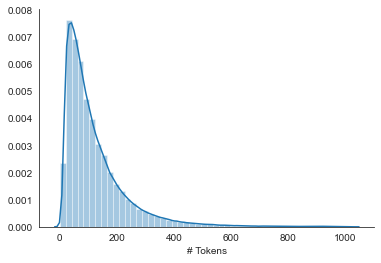

In [18]:
ax = sns.distplot(sample.text.str.split().str.len())
ax.set_xlabel('# Tokens')
sns.despine();

## Doc2Vec

### Basic text cleaning

In [19]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def clean(review):
    tokens = tokenizer.tokenize(review)
    return ' '.join([t for t in tokens if t not in stopword_set])

In [20]:
sample.text = sample.text.str.lower().apply(clean)

In [21]:
sample.sample(n=10)

,stars,text
106676,2.0,ordered guinea pig pizza read great reviews ca...
388751,4.0,great stop us way highpoint hubby craving shri...
235104,3.0,read roger review waiting show start thought h...
422459,5.0,finally broke tried ocp past weekend found cli...
366460,4.0,mary neill couple times drinks apps apps prett...
84223,1.0,going honest came dominoes temporarily closed ...
190363,2.0,tell much wanted like place counting days open...
282482,3.0,three stars may seem little harsh one sandwich...
388041,4.0,family goes breakfast brunch weekends great li...
136831,2.0,gone twice food amazing however staff much car...


In [22]:
sample = sample[sample.text.str.split().str.len()>10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485725 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   485725 non-null  float64
 1   text    485725 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.1+ MB


### Create sentence stream

In [23]:
sentences = []
for i, (_, text) in enumerate(sample.values):
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

### Formulate the model

In [24]:
model = Doc2Vec(documents=sentences,
                dm=1,           # 1=distributed memory, 0=dist.BOW
                epochs=5,
                size=300,       # vector size
                window=5,       # max. distance betw. target and context
                min_count=50,   # ignore tokens w. lower frequency
                negative=5,     # negative training samples
                dm_concat=0,    # 1=concatenate vectors, 0=sum
                dbow_words=0,   # 1=train word vectors as well
                workers=4)

In [25]:
pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])

,token,similarity
0,great,0.757694
1,decent,0.746465
2,awesome,0.622731
3,amazing,0.611350
4,bad,0.605432
5,yummy,0.600379
6,ok,0.600137
7,tasty,0.596531
8,excellent,0.594958
9,okay,0.592447


### Continue training

In [26]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [27]:
most_similar = pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])
most_similar

,token,similarity
0,great,0.745322
1,decent,0.712028
2,awesome,0.618959
3,amazing,0.608737
4,excellent,0.605081
5,fantastic,0.577577
6,yummy,0.569521
7,tasty,0.555287
8,bad,0.543677
9,delicious,0.539020


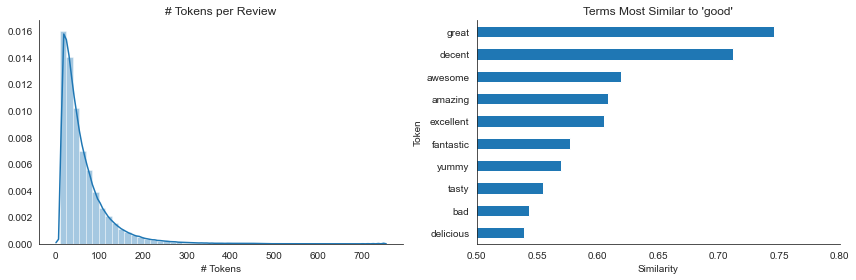

In [28]:
fig, axes =plt.subplots(ncols=2, figsize=(12, 4))
sns.distplot(sample.text.str.split().str.len(), ax=axes[0])
axes[0].set_title('# Tokens per Review')

most_similar.set_index('token').similarity.sort_values().plot.barh(ax=axes[1], 
                                                                   title="Terms Most Similar to 'good'",
                                                                  xlim=(.5, .8))
axes[1].set_xlabel('Similarity')
axes[1].set_ylabel('Token')
axes[0].set_xlabel('# Tokens')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'doc2vec_stats', dpi=300)

## Persist Model

In [29]:
model.save((results_path / 'sample.model').as_posix())

In [30]:
model = Doc2Vec.load((results_path / 'sample.model').as_posix())

## Evaluate

In [31]:
y = sample.stars.sub(1)

In [32]:
size = 300
X = np.zeros(shape=(len(y), size))
for i in range(len(sample)):
    X[i] = model.docvecs[i]

In [33]:
X.shape

(485725, 300)

### Train-Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [35]:
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 20.15%


In [36]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [37]:
class_weights

array([0.99618017, 0.9923514 , 0.99524889, 1.00219225, 1.01433084])

## LightGBM

In [38]:
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = train_data.create_valid(X_test, label=y_test)

In [39]:
params = {'objective': 'multiclass',
          'num_classes': 5}

In [40]:
lgb_model = lgb.train(params=params,
                      train_set=train_data,
                      num_boost_round=5000,
                      valid_sets=[train_data, test_data],
                      early_stopping_rounds=25,
                      verbose_eval=50)

Training until validation scores don't improve for 25 rounds
[50]	training's multi_logloss: 1.44166	valid_1's multi_logloss: 1.45977
[100]	training's multi_logloss: 1.38412	valid_1's multi_logloss: 1.41755
[150]	training's multi_logloss: 1.3404	valid_1's multi_logloss: 1.38813
[200]	training's multi_logloss: 1.30368	valid_1's multi_logloss: 1.36524
[250]	training's multi_logloss: 1.272	valid_1's multi_logloss: 1.34701
[300]	training's multi_logloss: 1.24457	valid_1's multi_logloss: 1.33252
[350]	training's multi_logloss: 1.22035	valid_1's multi_logloss: 1.32092
[400]	training's multi_logloss: 1.1986	valid_1's multi_logloss: 1.31161
[450]	training's multi_logloss: 1.17894	valid_1's multi_logloss: 1.30414
[500]	training's multi_logloss: 1.16084	valid_1's multi_logloss: 1.29773
[550]	training's multi_logloss: 1.14419	valid_1's multi_logloss: 1.29242
[600]	training's multi_logloss: 1.1284	valid_1's multi_logloss: 1.28762
[650]	training's multi_logloss: 1.11312	valid_1's multi_logloss: 1.28

In [41]:
lgb_pred = np.argmax(lgb_model.predict(X_test), axis=1)

In [42]:
lgb_acc = accuracy_score(y_true=y_test, y_pred=lgb_pred)
print(f'Accuracy: {lgb_acc:.2%}')

Accuracy: 55.01%


## Random Forest

In [44]:
rf = RandomForestClassifier(n_jobs=-1,  
                            n_estimators=500,
                            verbose=1,
                            class_weight='balanced_subsample')
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.3min finished


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1, verbose=1)

In [45]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=rf_pred)
print(f'Accuracy: {rf_acc:.2%}')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.2s


Accuracy: 37.37%


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    7.1s finished


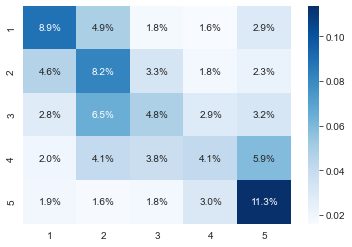

In [46]:
cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Multinomial Logistic Regression

In [47]:
lr = LogisticRegression(multi_class='multinomial', 
                        solver='lbfgs', 
                        class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [48]:
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=lr_pred)
print(f'Accuracy: {lr_acc:.2%}')

Accuracy: 33.72%


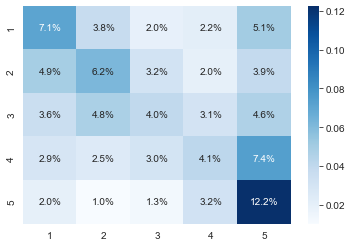

In [49]:
cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Comparison

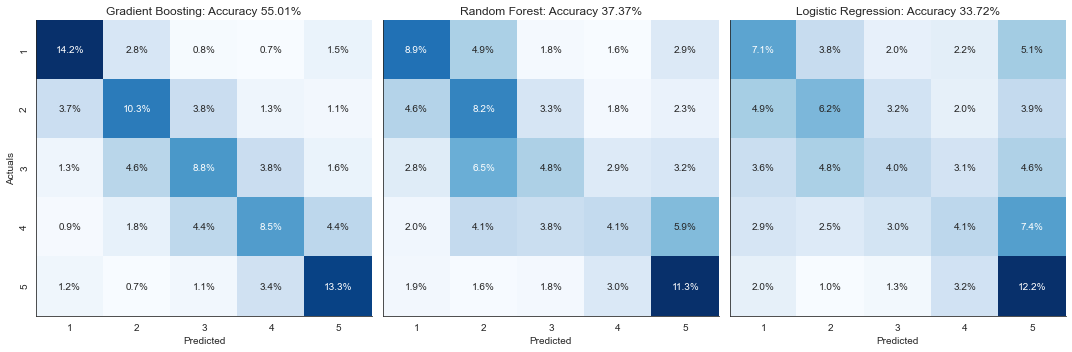

In [50]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

lgb_cm = confusion_matrix(y_true=y_test, y_pred=lgb_pred)
sns.heatmap(pd.DataFrame(lgb_cm/np.sum(lgb_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[0], cbar=False)
axes[0].set_title(f'Gradient Boosting: Accuracy {lgb_acc:.2%}')

rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(rf_cm/np.sum(rf_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[1], cbar=False)
axes[1].set_title(f'Random Forest: Accuracy {rf_acc:.2%}')

lr_cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(lr_cm/np.sum(lr_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[2], cbar=False)
axes[2].set_title(f'Logistic Regression: Accuracy {lr_acc:.2%}')
axes[0].set_ylabel('Actuals')
for i in range(3):
    axes[i].set_xlabel('Predicted')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'confusion_matrix', dpi=300)